# Multimodal search for E-commerce

Cohere's embeddings model, Embed 3 is an industry-leading AI search model that is designed to transform semantic search and generative AI applications. Cohere Embed 3 is now multimodal and it is capable of generating embeddings from both text and images. This enables enterprises to unlock real value from their vast amounts of data that exist in image form. Businesses can now build systems that accurately search important multimodal assets such as complex reports, ecommerce product catalogs, and design files to boost workforce productivity. This upgrade makes Embed 3 the most generally capable multimodal embedding model on the market. 

### Getting started

Imports and Install Dependencies

In [217]:
!pip install striprtf boto3 cohere-aws setuptools==69.5.1 wheel hnswlib pandas markdown --quiet
import pandas as pd
import numpy as np
import cohere_aws
import hnswlib
import warnings
import boto3
import json
import markdown as md
import requests
import base64
import os
import mimetypes
from IPython.display import Image, display
import tqdm
import tqdm.auto
from IPython.display import HTML
warnings.filterwarnings('ignore')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.10 requires mkl, which is not installed.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


### Connect to Bedrock

In [205]:
#connect to Bedrock endpoint for embed
#co= cohere_aws.Client(mode=cohere_aws.Mode.BEDROCK)
model_id = "cohere.embed-english-v3"

bedrock_runtime = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-west-2" # Replace with your AWS region
)


### Helper functions

Helper function that determine whether input document is text or image, and download images given a list of URLs.

In [206]:
def is_image(doc):
    return (doc.endswith(".jpg") or doc.endswith(".png")) and os.path.exists(doc)

def is_txt(doc):
    return (doc.endswith(".txt")) and os.path.exists(doc)

def download_images(image_urls):
    image_names = []

    #print("Download some example images we want to embed")
    for url in image_urls:
        image_name = os.path.basename(url)
        image_names.append(image_name)

        if not os.path.exists(image_name):
            with open(image_name, "wb") as fOut:
                fOut.write(requests.get(url, stream=True).content)
    return image_names

### Generate embedding for text/image inputs

Define compute_embeddings() function to accept multi-modal inputs to generate embeddings with Cohere Embed 3.


In [207]:
def compute_embeddings(docs):
    # Compute the embeddings
    embeddings = []
    for doc in tqdm.auto.tqdm(docs, desc="encoding"):
        if is_image(doc):
            print("Encode image:", doc)
            # Doc is an image, encode it as an image

            # Convert the images to base64
            with open(doc, "rb") as fIn:
                img_base64 = base64.b64encode(fIn.read()).decode("utf-8")
            
            #Get the mime type for the image
            mime_type = mimetypes.guess_type(doc)[0]
            
            body = json.dumps({
                "images": [f"data:{mime_type};base64,{img_base64}"],
                "input_type": "image"
            })
            
            response = bedrock_runtime.invoke_model(
                body=body,
                modelId=model_id,
                accept="application/json",
                contentType="application/json"
            )

            response_body = json.loads(response.get("body").read())
            emb_response = response_body.get("embeddings")[0]
        elif is_txt(doc):
            # Doc is a text file, encode it as a document
            with open(doc, "r") as fIn:
                text = fIn.read()

            print("Encode img desc:", doc, " - Content:", text[0:100]+"...")
            
            body = json.dumps({
                "texts": [text],              
                "input_type": "search_document"
            })
          
            response = bedrock_runtime.invoke_model(
                body=body,
                modelId=model_id,
                contentType="application/json"
            )

            response_body = json.loads(response.get("body").read())
            emb_response = response_body.get("embeddings")[0]
        else:
            print("Encode text:", doc)
            #Encode as document
            body = json.dumps({
                "texts": [doc],              
                "input_type": "search_document"
            })
          
            response = bedrock_runtime.invoke_model(
                body=body,
                modelId=model_id,
                contentType="application/json"
            )

            response_body = json.loads(response.get("body").read())
            emb_response = response_body.get("embeddings")[0]
        embeddings.append(emb_response)
    return np.asarray(embeddings, dtype="float")


### Finding the most relevant embedding based on query

Search() function generates query embedding and computes a similarity matrix between the query and image.text embeddings


In [208]:
def search(query, embeddings, docs):
    body = json.dumps({
        "texts": [query], 
        "input_type": "search_query"
    })
            
    response = bedrock_runtime.invoke_model(
        body=body,
        modelId=model_id,
        contentType="application/json"
     )

    response_body = json.loads(response.get("body").read())
    query_emb = response_body.get("embeddings")[0]
    
    # Compute L2 norms of the vector and matrix rows
    vector_norm = np.linalg.norm(query_emb)
    matrix_norms = np.linalg.norm(embeddings, axis = 1)

    # Compute the dot product between the vector and each row of the matrix
    dot_products = np.dot(embeddings, query_emb)
    
    # Compute cosine similarities
    similarity = dot_products / (matrix_norms * vector_norm)

    # Sort decreasing most to least similar
    top_hits = np.argsort(-similarity)

    print("Query:", query, "\n")
    print("Search results:")
    for rank, idx in enumerate(top_hits):
        print(f"#{rank+1}: ({similarity[idx]*100:.2f})")
        if is_image(docs[idx]):
            print(docs[idx])
            display(Image(filename=docs[idx], height=300))
        elif is_txt(docs[idx]):
            print(docs[idx]+" - Image description:")
            with open(docs[idx], "r") as fIn:
                print(fIn.read())
        else:
            print(docs[idx])
        print("--------")


### Now let’s see how this work in action!

Let’s first assemble all the input documents, notice that there are both text and image inputs.


In [209]:
# Download images
image_urls = [
    "https://images-na.ssl-images-amazon.com/images/I/31KqpOznU1L.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41RI4qgJLrL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/61NbJr9jthL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/31TW1NCtMZL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/51a6iOTpnwL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/31sa-c%2BfmpL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/41sKETcJYcL.jpg",
    "https://images-na.ssl-images-amazon.com/images/I/416GZ2RZEPL.jpg"
]
image_names = download_images(image_urls)
text_docs = [
    "Toy with 10 activities including a storybook, clock, gears; 13 double-sided alphabet blocks build fine motor skills and introduce letters, numbers, colors, and more.",
    "This is the perfect introduction to the world of scooters.",
    "2 -IN-1 RIDE-ON TOY- This convertible scooter is designed to grow with your child.",
    "Playful elephant toy makes real elephant sounds and fun music to inspire imaginative play."
]

docs = image_names + text_docs
print("Total docs:", len(docs))
print(docs)

Total docs: 12
['31KqpOznU1L.jpg', '41RI4qgJLrL.jpg', '61NbJr9jthL.jpg', '31TW1NCtMZL.jpg', '51a6iOTpnwL.jpg', '31sa-c%2BfmpL.jpg', '41sKETcJYcL.jpg', '416GZ2RZEPL.jpg', 'Toy with 10 activities including a storybook, clock, gears; 13 double-sided alphabet blocks build fine motor skills and introduce letters, numbers, colors, and more.', 'This is the perfect introduction to the world of scooters.', '2 -IN-1 RIDE-ON TOY- This convertible scooter is designed to grow with your child.', 'Playful elephant toy makes real elephant sounds and fun music to inspire imaginative play.']


In [210]:
embeddings = compute_embeddings(docs)
print("Doc embeddings shape:", embeddings.shape)

encoding:   0%|          | 0/12 [00:00<?, ?it/s]

Encode image: 31KqpOznU1L.jpg
Encode image: 41RI4qgJLrL.jpg
Encode image: 61NbJr9jthL.jpg
Encode image: 31TW1NCtMZL.jpg
Encode image: 51a6iOTpnwL.jpg
Encode image: 31sa-c%2BfmpL.jpg
Encode image: 41sKETcJYcL.jpg
Encode image: 416GZ2RZEPL.jpg
Encode text: Toy with 10 activities including a storybook, clock, gears; 13 double-sided alphabet blocks build fine motor skills and introduce letters, numbers, colors, and more.
Encode text: This is the perfect introduction to the world of scooters.
Encode text: 2 -IN-1 RIDE-ON TOY- This convertible scooter is designed to grow with your child.
Encode text: Playful elephant toy makes real elephant sounds and fun music to inspire imaginative play.
Doc embeddings shape: (12, 1024)


### Provide search query

Result is a mix of both text and images based on the similarity scroe of the query to the embedded documents.

Query: Educative toys 

Search results:
#1: (52.14)
61NbJr9jthL.jpg


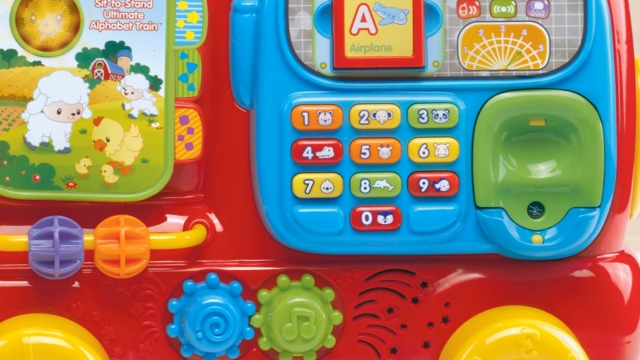

--------
#2: (51.61)
Toy with 10 activities including a storybook, clock, gears; 13 double-sided alphabet blocks build fine motor skills and introduce letters, numbers, colors, and more.
--------
#3: (50.52)
416GZ2RZEPL.jpg


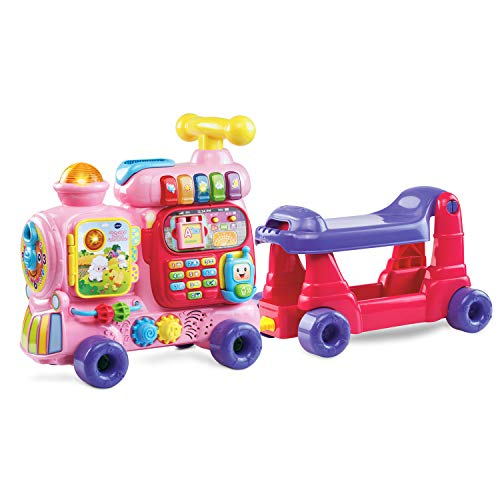

--------
#4: (46.52)
Playful elephant toy makes real elephant sounds and fun music to inspire imaginative play.
--------
#5: (43.25)
31sa-c%2BfmpL.jpg


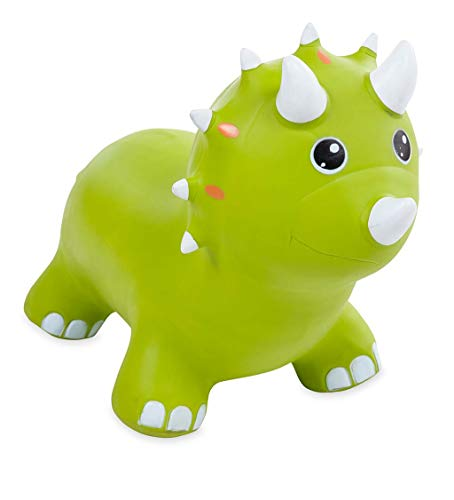

--------
#6: (42.57)
41sKETcJYcL.jpg


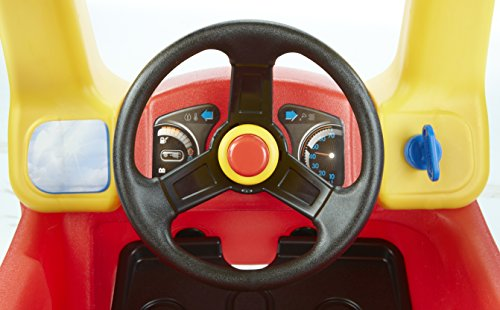

--------
#7: (41.31)
41RI4qgJLrL.jpg


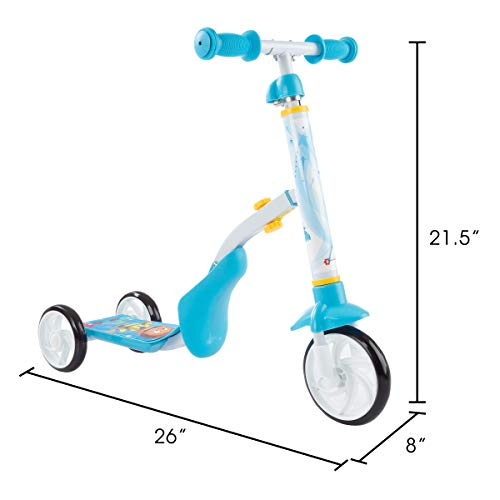

--------
#8: (39.08)
51a6iOTpnwL.jpg


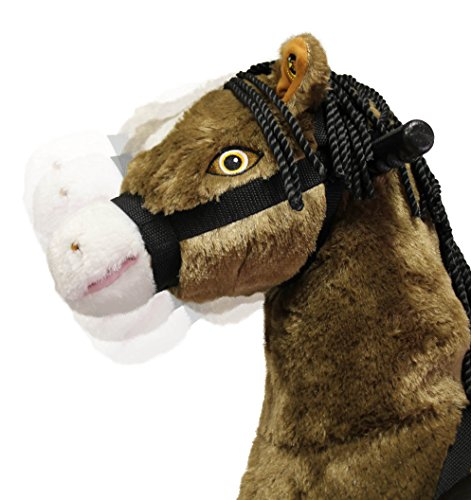

--------
#9: (37.97)
31TW1NCtMZL.jpg


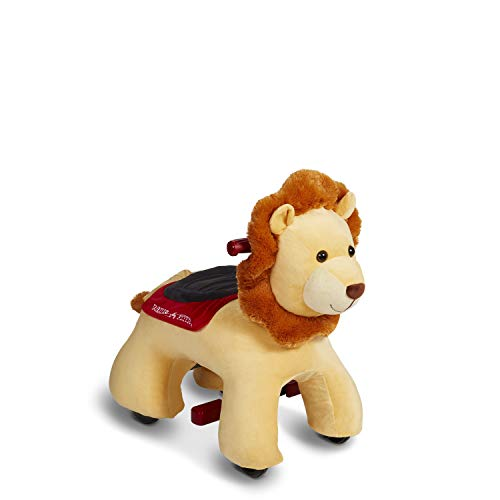

--------
#10: (37.42)
31KqpOznU1L.jpg


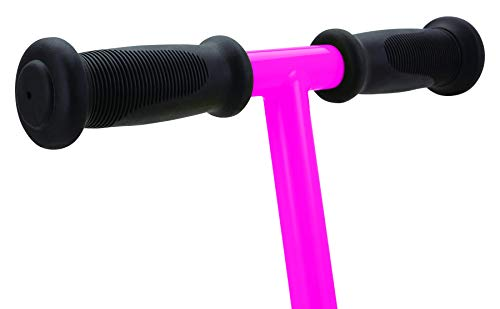

--------
#11: (34.29)
2 -IN-1 RIDE-ON TOY- This convertible scooter is designed to grow with your child.
--------
#12: (26.54)
This is the perfect introduction to the world of scooters.
--------


In [214]:
search("Educative toys", embeddings, docs)

Query: Toys that make sounds to spark imagination 

Search results:
#1: (61.73)
Playful elephant toy makes real elephant sounds and fun music to inspire imaginative play.
--------
#2: (51.14)
61NbJr9jthL.jpg


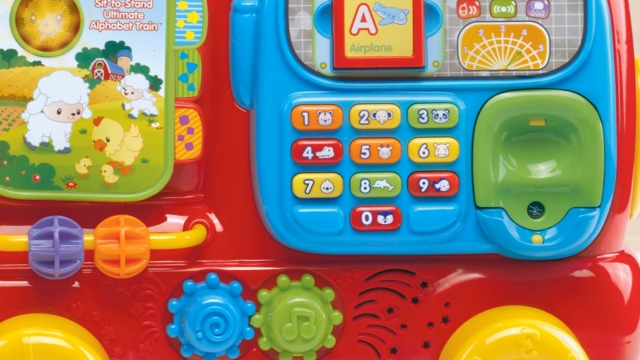

--------
#3: (48.48)
416GZ2RZEPL.jpg


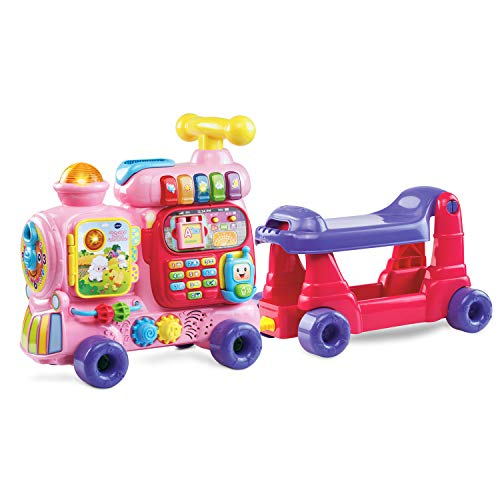

--------
#4: (48.25)
31sa-c%2BfmpL.jpg


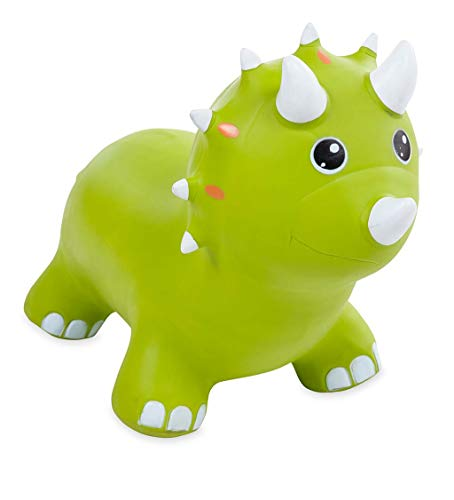

--------
#5: (44.38)
51a6iOTpnwL.jpg


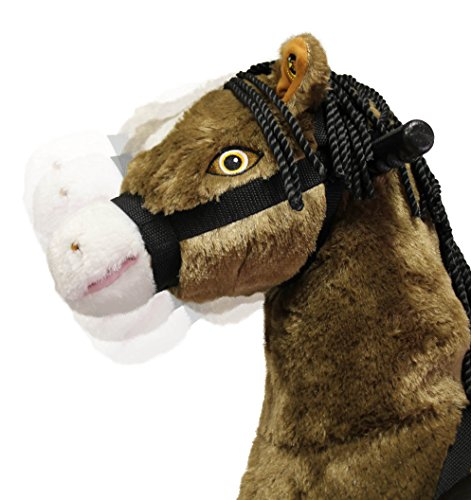

--------
#6: (44.12)
41sKETcJYcL.jpg


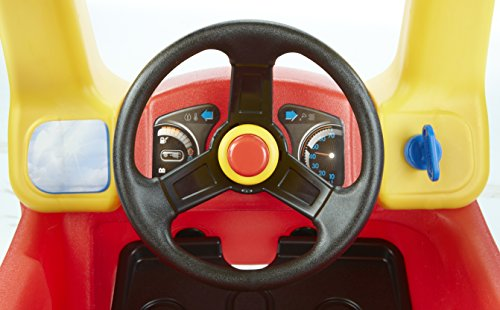

--------
#7: (43.49)
Toy with 10 activities including a storybook, clock, gears; 13 double-sided alphabet blocks build fine motor skills and introduce letters, numbers, colors, and more.
--------
#8: (42.28)
31TW1NCtMZL.jpg


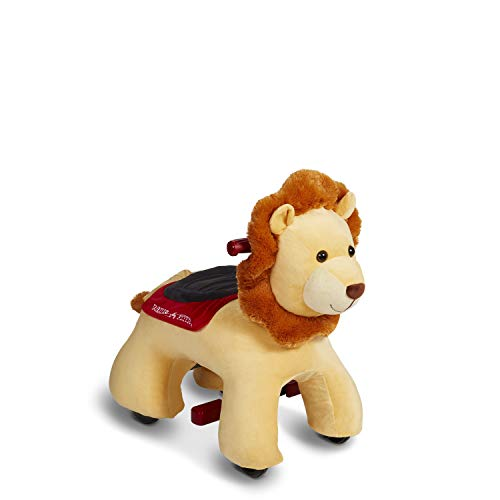

--------
#9: (39.25)
41RI4qgJLrL.jpg


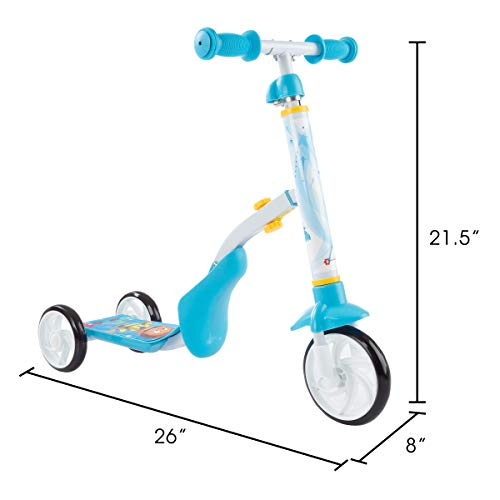

--------
#10: (37.23)
31KqpOznU1L.jpg


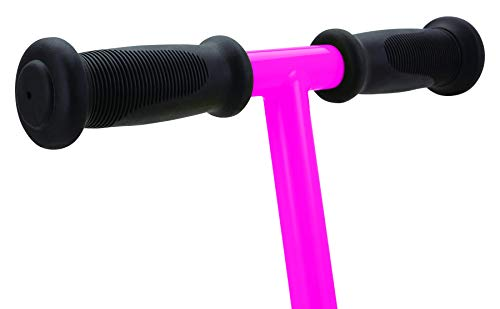

--------
#11: (30.07)
2 -IN-1 RIDE-ON TOY- This convertible scooter is designed to grow with your child.
--------
#12: (24.79)
This is the perfect introduction to the world of scooters.
--------


In [216]:
search("Toys that make sounds to spark imagination", embeddings, docs)

## Conclusion

In this notebook we walked through how to leverage Cohere's Embed V3 multimodal model, capable of generating embeddings from both text and images. This enables enterprises to unlock value from their vast image data, allowing them to build powerful search and recommendation systems across multimodal assets like product catalogs, design files, and business reports. 

Cohere Embed 3 is now available on Amazon Bedrock, allowing customers to seamlessly deploy this state-of-the-art multimodal embeddings model and leverage it in their own applications. Key use cases include enhanced e-commerce search, efficient data-driven decision making with visual insights, and streamlined creative workflows.